TODOs

* check whether performance is better with amplitude or intensity as model output
* make the model robust to arbitrary scaling/incorrect normalization of the diffracted intensity
* other ideas: fft based loss, gradient loss, vq-vae https://www.tensorflow.org/tutorials/generative/style_transfer#define_content_and_style_representations
* probe-based vs reconstruction-based support?

* Use perceptual loss for reconstruction. Need to set the weights. Read Perceptual Losses for Real-Time Style Transfer
and Super-Resolution
* Reflection invariance: do augmentation to reflect this. (done / n/a)
* consistency check on magnitude constraint (done)
* Fully Convolutional Networks for Semantic Segmentation, explore and discuss. Make a slide explaining the idea.
* Try MC Dropout https://arxiv.org/pdf/1511.02680.pdf
* Put poisson likelihood into data (done)
* read deep ensembles https://arxiv.org/pdf/1612.01474.pdf
* overlap condition -> resolution? 
* residual blocks?
* blur diffraction by 1 pixel in preprocessing or do pairwise linear interpolation. if blurring, then gaussian instead of poisson likelihood should be used.
* what does trainable option do?
* paper that ashwin mentioned
* does adding a random global phase break the symmetry?
* handle symmetry in perceptual loss


* Poisson augmentation
* smoothing interpolation
* hard constraint on diffraction norm using projection, consider tf.keras.constraints.MinMaxNorm
* DFT channel dimension

misc notes:

clearing gpu memory: `for i in $(sudo lsof /dev/nvidia0 | grep python | awk '{print $2}' | sort -u); do sudo kill -9 $i; done`
https://github.com/tensorflow/tensorflow/issues/36465

In [5]:
import os
import tf_helper as hh
import fourier as f

import tensorflow_probability as tfp


tfk = hh.tf.keras
tfkl = hh.tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

path = '.'

from importlib import reload
import sys
import os
sys.path.append(path)
sys.path.append('PtychoNN/TF2/')

import tensorflow as tf

from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras import Model

import importlib
import matplotlib.pyplot as plt
import numpy as np
import glob
from tqdm.notebook import tqdm as tqdm
%matplotlib inline
import matplotlib

import keras_helper

from tensorflow.keras.layers import Layer
from math import pi
from tensorflow.keras import backend as K

# importlib.reload(keras_helper)
# from keras_helper import *
from skimage.transform import resize

matplotlib.rcParams['font.size'] = 12

#config = tf.ConfigProto() 
#config.gpu_options.allow_growth=True 
#session = tf.Session(config=config)
#K.set_session(session)

In [6]:
import datasets

In [7]:
from sklearn.utils import shuffle

In [8]:
!nvidia-smi

/bin/bash: /home/ollie/anaconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Oct 25 15:23:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   51C    P8    43W / 420W |   2090MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

### Some training parameters

In [9]:
h = w = N =64
nepochs=20
#wt_path = 'wts4' #Where to store network weights
wt_path = 'wts4.1'
batch_size = 32

filt = f.lowpass_g(.6, np.ones(h), sym = True)

# TODO assert symmetry
probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
probe_small = probe[16:-16, 16:-16]
tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# if (not os.path.isdir(path+wt_path)):
#     os.mkdir(wt_path)

### Load experimental dataset

In [10]:
# ### Read experimental diffraction data and reconstructed images

# data_diffr = np.load(path+'/PtychoNN/data/20191008_39_diff.npz')['arr_0']
# data_diffr.shape

# #plt.matshow(np.log10(data_diffr[0,0]))

# data_diffr_red = np.zeros((data_diffr.shape[0],data_diffr.shape[1],64,64), float)
# for i in tqdm(range(data_diffr.shape[0])):
#     for j in range(data_diffr.shape[1]):
#         data_diffr_red[i,j] = resize(data_diffr[i,j,32:-32,32:-32],(64,64),preserve_range=True, anti_aliasing=True)
#         data_diffr_red[i,j] = np.where(data_diffr_red[i,j]<3,0,data_diffr_red[i,j])

# real_space = np.load(path+'/PtychoNN/data/20191008_39_amp_pha_10nm_full.npy')
# amp = np.abs(real_space)
# ph = np.angle(real_space)
# amp.shape

# # fig,ax = plt.subplots(1,2,figsize=(20,10))
# # ax[0].imshow(amp[:,:,32,32])
# # ax[1].imshow(ph[:,:,32,32])

# ### Split data and then shuffle

# nlines = 100 #How many lines of data to use for training?
# nltest = 60 #How many lines for the test set?
# tst_strt = amp.shape[0]-nltest #Where to index from
# print(tst_strt)

# filt = f.lowpass_g(.6, np.ones(h), sym = True)
# #filt = f.lowpass_g(.9, np.ones(h), sym = True)
# # TODO assert symmetry
# probe = f.gf(((np.einsum('i,j->ij', filt, filt)) > .5).astype(float), 1) + 1e-9
# probe_small = probe[16:-16, 16:-16]
# tprobe = (tf.convert_to_tensor(probe, tf.float32)[..., None])
# tprobe_small = (tf.convert_to_tensor(probe_small, tf.float32)[..., None])

# plt.imshow(probe)

# N = h
# assert h == w

# from sklearn.model_selection import train_test_split

# # def blowup(img):
# #     N = img.shape[0]
# #     assert img.shape[1] == N
# #     cropped = img[N // 4: -N // 4, N // 4: -N // 4]
# #     return resize(cropped.copy(), (N, N))

# def stack(a1, a2):
#     return np.array((a1, a2)).reshape((-1, N, N, 1))

# def augment_inversion(Y_I_train, Y_phi_train):
#     phi = stack(Y_phi_train, -Y_phi_train)
# #     phi_off = np.random.uniform(size = phi.size).reshape(phi.shape)
# #     phi = np.mod(phi + phi_off)
#     return stack(Y_I_train, Y_I_train[:, ::-1, ::-1, :]), stack(Y_phi_train, -Y_phi_train)

# X_train = data_diffr_red[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# X_test = data_diffr_red[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_I_train = amp[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_I_test = amp[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_phi_train = ph[:nlines,:].reshape(-1,h,w)[:,:,:,np.newaxis]
# Y_phi_test = ph[tst_strt:,tst_strt:].reshape(-1,h,w)[:,:,:,np.newaxis]

# ntrain = X_train.shape[0]*X_train.shape[1]
# ntest = X_test.shape[0]*X_test.shape[1]

# print(X_train.shape, X_test.shape)

# # # resize to fill the grid better
# # X_train = np.array([blowup(arr) for arr in X_train]) * probe[None, ..., None]
# # X_test = np.array([blowup(arr) for arr in X_test]) * probe[None, ..., None]

# tmp1, tmp2 = Y_I_train, Y_I_test

# # X_train = np.array(hh.pad_and_diffract(Y_I_train, h, w, pad=False)[1])
# # X_test = np.array(hh.pad_and_diffract(Y_I_test, h, w, pad=False)[1])

In [12]:
reload(hh)

<module 'tf_helper' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/tf_helper.py'>

### Simulate ptychography measurements

In [14]:
nphotons = 1e8

def observe_amplitude(amplitude):
    """
    Sample photons from wave amplitudes by drwaing from the corresponding Poisson distributions
    """
    return tf.sqrt((tfd.Independent(tfd.Poisson(amplitude**2))).sample())# + 0.5

def scale_nphotons(padded_obj):
    """
    Scale real space object to the desired *expected* number of observed photons.
    Returns a tensor of scaling constants.
    """
#     padded_obj = padded_obj * tf.cast(tprobe, tf.complex64)[None, ...]
    prenorm = tf.math.reduce_sum(padded_obj, (1, 2, 3))
    norm = tf.math.sqrt(nphotons / prenorm)[:, None, None, None]
    return norm

def _preprocess(sample):
    # run ff diffraction
    amplitude = hh.pad_and_diffract(sample, h, w, pad=False)[1]
#     return amplitude
    # sample from Poisson observation likelihood
    observed_amp = observe_amplitude(amplitude)
    return observed_amp

def preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test):
    Y_I_train = Y_I_train *  probe[None, ..., None]
    Y_I_test = Y_I_test *  probe[None, ..., None]

    Y_I_train, Y_phi_train = shuffle(Y_I_train, Y_phi_train, random_state=0)

    obj_train = hh.combine_complex(Y_I_train, Y_phi_train)
    obj_train = scale_nphotons(obj_train) * obj_train
    
    obj_test = hh.combine_complex(Y_I_test, Y_phi_test)
    obj_test = scale_nphotons(obj_test) * obj_test
    
    Y_I_train = tf.math.abs(obj_train)
    Y_I_test = tf.math.abs(obj_test)

    # Simulate diffraction
    X_train = (tf.data.Dataset.from_tensor_slices(obj_train)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_train = np.vstack(list(iter(X_train)))

    X_test = (tf.data.Dataset.from_tensor_slices(obj_test)
               .batch(batch_size)
               .prefetch(tf.data.AUTOTUNE)
               .map(_preprocess)
               .cache())
    X_test = np.vstack(list(iter(X_test)))
    
    # 'empirical' because this value is stochastic
    empirical_norm = tf.math.maximum(tf.math.reduce_max(Y_I_train), tf.math.reduce_max(Y_I_test))

    return X_train / empirical_norm, Y_I_train / empirical_norm, Y_phi_train,\
        X_test / empirical_norm, Y_I_test / empirical_norm, Y_phi_test


### Generate dataset based on randomly-oriented lines

In [15]:
reload(datasets)

<module 'datasets' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/datasets.py'>

In [16]:
np.random.seed(1) # TODO some seed values result in unstable training
Y_I_train = np.array([datasets.mk_lines_img() for _ in range(15000)])[:, :, :, :1]
Y_I_test = np.array([datasets.mk_lines_img() for _ in range(5000)])[:, :, :, :1]

In [17]:
# Y_phi_train = np.array([datasets.mk_lines_img() for _ in range(15000)])[:, :, :, :1]
# Y_phi_test = np.array([datasets.mk_lines_img() for _ in range(5000)])[:, :, :, :1]

# Y_phi_train = -Y_I_train
# Y_phi_test = -Y_I_test

# # pm = Y_phi_train.mean() / 2
# rng = Y_phi_train.max() - Y_phi_train.min()
# Y_phi_train = (((Y_phi_train - Y_phi_train.min()) / rng) * 2 * np.pi - np.pi)
# Y_phi_test = (((Y_phi_test - Y_phi_test.min()) / rng) * 2 * np.pi - np.pi)

## Set object phase

# tmp1 = (4 * np.linspace(-1, 1., N))
# tmp2 = (5 * np.linspace(-1, 1., N))

# Y_phi_train[:] = ((tmp1) * tmp1[:, None] * np.pi / 2)[..., None]
# Y_phi_test[:] = ((tmp2) * tmp2[:, None] * np.pi / 2)[..., None]

Y_phi_train = np.zeros_like(Y_I_train)
Y_phi_test = np.zeros_like(Y_I_test)

# Y_phi_train = hh.gf(np.random.uniform(size = Y_phi_train.shape), (0, 5, 5, 0)) * 4
# Y_phi_test = hh.gf(np.random.uniform(size = Y_phi_test.shape), (0, 5, 5, 0)) * 4

# tmp = np.linspace(-1, 1., N)

# Y_phi_train[:] = ((tmp) * tmp[:, None] * np.pi / 2)[..., None]
# Y_phi_test[:] = ((tmp) * tmp[:, None] * np.pi / 2)[..., None]

In [18]:
Y_I_test.shape

(5000, 64, 64, 1)

In [19]:
X_train, Y_I_train, Y_phi_train, X_test, Y_I_test, Y_phi_test =\
    preprocess(Y_I_train, Y_phi_train, Y_I_test, Y_phi_test)

(Y_phi_test).shape, (Y_I_test).shape, Y_I_train.shape
#Y_I_train.max(axis = 3).max(axis = 2).max(axis = 1).argmax()

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


((5000, 64, 64, 1),
 TensorShape([5000, 64, 64, 1]),
 TensorShape([15000, 64, 64, 1]))

### Norm conservation consistency check:

In [20]:
print(np.linalg.norm(X_train[0]) /  np.linalg.norm(Y_I_train[0]))

import fourier as f
def normed_ff_np(arr):
    return (f.fftshift(np.absolute(f.fft2(np.array(arr)))) / np.sqrt(h * w))

1.0000043


### Inversion symmetry check:

In [21]:
# assert (normed_ff_np(Y_I_train[0, :, :, 0])[::-1, ::-1] == normed_ff_np(Y_I_train[0, ::-1, ::-1, 0])).all()

normed_ff_np(Y_I_train[0, :, :, 0]).sum() / normed_ff_np(Y_I_train[0, :, :, 0]).sum()

1.0

### np / tf consistency check:

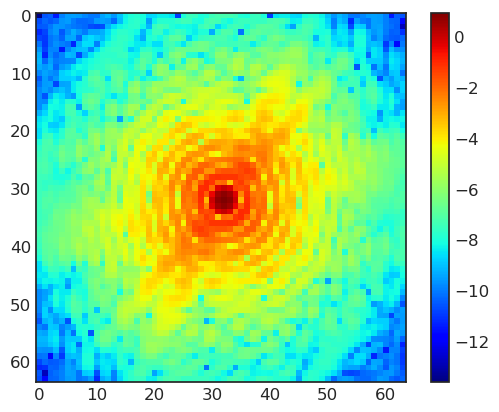

In [22]:
i = 0

plt.imshow(np.log(normed_ff_np
                  (np.array(hh.combine_complex(Y_I_train, Y_phi_train))[0, :, :, 0])), cmap = 'jet')
plt.colorbar()

/tmp/ipykernel_347436/2642748978.py:1: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')


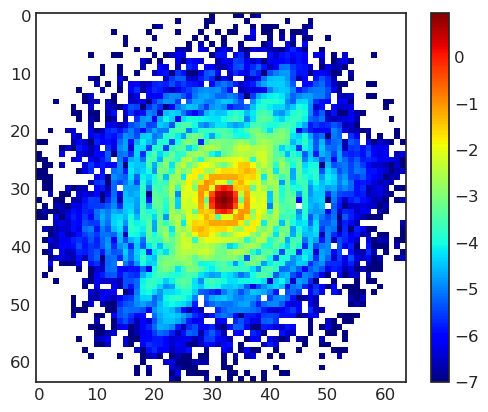

In [23]:
plt.imshow(np.log(X_train[0, :, :, 0]), cmap = 'jet')
plt.colorbar()

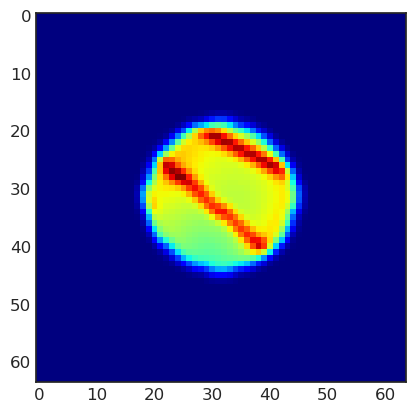

In [27]:
plt.imshow((np.squeeze(Y_I_train[i])), cmap = 'jet')

In [28]:
### Recover shift between scan points

# import numpy as np
# import scipy.signal

# def cross_image(im1, im2):
#     # get rid of the color channels by performing a grayscale transform
#     # the type cast into 'float' is to avoid overflows
#     im1_gray = im1#np.sum(im1.astype('float'), axis=2)
#     im2_gray = im2#np.sum(im2.astype('float'), axis=2)

#     # get rid of the averages, otherwise the results are not good
#     im1_gray -= np.mean(im1_gray)
#     im2_gray -= np.mean(im2_gray)

#     # calculate the correlation image; note the flipping of onw of the images
#     return scipy.signal.fftconvolve(im1_gray, im2_gray[::-1,::-1], mode='same')

### Full diffraction, no probe envelope:

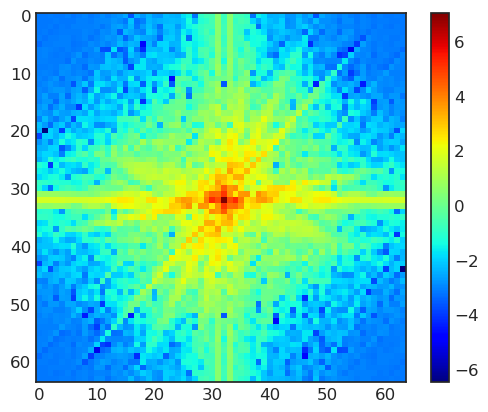

In [29]:
forward = (np.absolute(f.fftshift(f.fft2(f.gf(Y_I_train[i] / probe[..., None], 0.).squeeze()))))

plt.imshow(np.log(f.gf(forward, 0)), cmap = 'jet')
plt.colorbar()

## Define the network structure

In [30]:
dummy_input = tf.zeros_like(X_train)

In [31]:
# %load keras_helper.py
#Keras modules
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, UpSampling2D
from tensorflow.keras import Sequential
from tensorflow.keras import Input
import numpy as np


def Conv_Pool_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = MaxPool2D((p1, p2), padding=padding, data_format=data_format)(x0)
    return x0

def Conv_Up_block(x0,nfilters,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last',
        activation = 'relu'):
    x0 = Conv2D(nfilters, (w1, w2), activation='relu', padding=padding, data_format=data_format)(x0)
    x0 = Conv2D(nfilters, (w1, w2), activation=activation, padding=padding, data_format=data_format)(x0)
    x0 = UpSampling2D((p1, p2), data_format=data_format)(x0)
    return x0

In [32]:
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.layers import Lambda

reload(hh)

import math

In [33]:
np.mod(5, 3.15)

1.85

In [34]:
def get_mask(input, support_threshold):
    mask = tf.where(tf.math.abs(input) > support_threshold, tf.ones_like(input),
                    tf.zeros_like(input))
    
#     mask = tf.where(tprobe[16:-16, 16:-16, :] > support_threshold, tf.ones_like(input),
#                     tf.zeros_like(input))
    return mask

def symmetrize(arr):
    return (arr + arr[::-1, ::-1]) / 2

def symmetrize_3d(arr):
    return (arr + arr[:, ::-1, ::-1]) / 2

plt.rcParams["figure.figsize"] = (10, 10)

def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)


def summarize(i):
    #norm =  (np.absolute(b)[i].max() / tmp2[i].max())
    # vmax = tmp2[i].max() * norm
    vmin = 0
    vmax = np.absolute(b)[i].max()

    aa, bb = 3, 3
    plt.subplot(aa, bb, 1)
    plt.title('Ground truth amp.')
    #cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((Y_I_test[i]), cmap = 'jet')

    plt.subplot(aa, bb, 2)
    plt.title('True amp. (symmetrized)')
    #cropshow((np.absolute(symmetrize(Y_I_test[i]))), cmap = 'jet', vmin = vmin, vmax = vmax)
    cropshow((np.absolute(symmetrize(Y_I_test[i]))), cmap = 'jet')

    plt.subplot(aa, bb, 3)
    plt.title('Reconstructed amp.')
    cropshow((np.absolute(b))[i] * probe[..., None], cmap = 'jet')
#     cropshow((np.absolute(b))[i] * probe[..., None], vmin = np.min(Y_I_test[i]),
#              vmax = np.max(Y_I_test[i]), cmap = 'jet')

    plt.subplot(aa, bb, 4)
    plt.title('Reconstructed phase')
    cropshow((np.angle(b) * (probe > .01)[..., None])[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 5)
    plt.title('True phase')
    cropshow(((Y_phi_test * (probe > .01)[..., None]))[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 6)
    plt.title('True diffraction')
    plt.imshow(np.log(X_test)[i], cmap = 'jet')
    
    plt.subplot(aa, bb, 7)
    plt.title('Recon diffraction')
    plt.imshow(np.log(a)[i], cmap = 'jet')
    
def plt_metrics():
    hist=history
    epochs=np.asarray(history.epoch)+1

    %matplotlib inline
    import matplotlib
    plt.style.use('seaborn-white')
    matplotlib.rc('font',family='Times New Roman')
    matplotlib.rcParams['font.size'] = 12

    f, axarr = plt.subplots(2, sharex=True, figsize=(12, 8))

    axarr[0].set(ylabel='Loss')
    axarr[0].plot(epochs,hist.history['loss'], 'C3o', label='Diffraction perceptual loss Training')
    axarr[0].plot(epochs,hist.history['val_loss'], 'C3-', label='Diffraction perceptual loss Validation')
    axarr[0].grid()
    axarr[0].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))

    axarr[1].set(ylabel='Loss')
    axarr[1].plot(epochs,hist.history['padded_obj_loss'], 'C0o', label='Object perceptual loss Training')
    axarr[1].plot(epochs,hist.history['val_padded_obj_loss'], 'C0-', label='Object perceptual loss Validation')
    axarr[1].legend(loc='center right', bbox_to_anchor=(1.5, 0.5))
    plt.xlabel('Epochs')
    plt.tight_layout()
    #plt.semilogy()
    axarr[1].grid()

In [35]:
#plt.imshow(tprobe[16:-16, 16:-16, :] > .05)

In [36]:
from tensorflow.keras.applications.vgg16 import VGG16

# vgg = VGG16(weights='imagenet', include_top=False, input_shape=(N // 2,N // 2,3))
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(N, N, 3))
vgg.trainable = False

outputs = [vgg.get_layer('block2_conv2').output]
feat_model = Model(vgg.input, outputs)
# feat_model.trainable = False

# @tf.function
# def perceptual_loss(input_image , reconstruct_image):
#     h1 = feat_model(input_image)
#     h2 = feat_model(reconstruct_image)

#     h1 = tf.keras.backend.batch_flatten(h1)
#     h2 = tf.keras.backend.batch_flatten(h2)
#     rc_loss = tf.sum(K.square(h1 - h2), axis=-1)
#     return rc_loss

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]
    return x_var, y_var

def total_variation_loss(target, pred):
    pred = tf.keras.layers.AveragePooling2D(padding = 'valid')(pred)
    x_deltas, y_deltas = high_pass_x_y(pred)
    return tf.reduce_mean(x_deltas**2) + tf.reduce_mean(y_deltas**2)

def pp_amplitude(img):
    return img#tf.math.log(1 + 10 * img)


pp = tfk.Sequential([
#     tf.keras.layers.AveragePooling2D(),
    Lambda(lambda x: tf.image.grayscale_to_rgb(x)),
])
def perceptual_loss(target, pred):
    """
    """
    target = pp(target)
#     target = pp_amplitude(target)
#     target = tf.keras.layers.AveragePooling2D(padding = 'valid')(target)
#     target = tf.image.grayscale_to_rgb(target)

    pred = pp(pred)
#     pred = tf.keras.layers.AveragePooling2D(padding = 'valid')(pred)
#     pred = pp_amplitude(pred)
#     pred = tf.image.grayscale_to_rgb(pred)
    
    activatedModelVal = feat_model(pred)
    actualModelVal = feat_model(target)
    return meanSquaredLoss(gram_matrix(actualModelVal),gram_matrix(activatedModelVal))

def symmetrized_loss(target, pred, loss_fn):
    """
    Calculate loss function on an image, taking into account that the prediction may be
    coordinate-inverted relative to the target
    """
    abs1 = (target)
    abs2 = (pred)
    abs3 = abs2[:, ::-1, ::-1, :]
    target_sym = (symmetrize_3d(target))
    a, b, c = loss_fn(abs1, abs2), loss_fn(abs1, abs3), loss_fn(target_sym, pred)
    return tf.minimum(a, 
                      tf.minimum(b, c))

def amplitude_difference(target, pred):
    """
    Calculate object MAE, taking into account that the prediction may be inverted
    """
    abs1 = tf.math.abs(target)
    abs2 = tf.math.abs(pred)
    return symmetrized_loss(target, pred, tf.keras.losses.MeanAbsoluteError())

def symmetrized_perceptual_loss(target, pred):
    return symmetrized_loss(target, pred, perceptual_loss)

def get_cm_agg(volumes):
    # Make array of coordinates (each row contains three coordinates)
    jj, kk = tf.meshgrid(tf.range(N), tf.range(N), indexing='ij')
    coords = tf.stack([tf.reshape(jj, (-1,)), tf.reshape(kk, (-1,))], axis=-1)
    coords = tf.cast(coords, tf.float32)
    # Rearrange input into one vector per volume
    volumes_flat = tf.reshape(volumes, [-1, N * N, volumes.shape[-1]])
    # Compute total mass for each volume
    total_mass = tf.reduce_sum(volumes_flat, axis=1)
    # Compute centre of mass
    centre_of_mass = tf.reduce_sum(volumes_flat * coords, axis=1) / total_mass
    return tf.math.reduce_mean(centre_of_mass[:, 0]) + tf.math.reduce_mean(centre_of_mass[:, 1])

def neg_L2_activation_regularization(target, pred):
    return tf.reduce_mean(tf.math.abs(pred))
#     return get_cm_agg(tf.math.abs(pred))
#     return -tf.reduce_mean(
#         tf.math.abs(tf.math.abs(pred) - tf.math.abs(pred[:, ::-1, ::-1])))
#     return -tf.keras.losses.MeanSquaredError()(target, pred)

# def amplitude_difference(target, pred):
#     """
#     Calculate object MAE, taking into account that the prediction may be inverted
#     """
#     abs1 = tf.math.abs(target)
#     abs2 = tf.math.abs(pred)
#     abs3 = abs2[:, ::-1, ::-1, :]
#     target_sym = tf.math.abs(symmetrize_3d(target))
#     mae = tf.keras.losses.MeanAbsoluteError()
#     a, b, c = mae(abs1, abs2), mae(abs1, abs3), mae(target_sym, pred)
#     return tf.minimum(a, 
#                       tf.minimum(b, c))

def meanSquaredLoss(y_true,y_pred):
    return tf.reduce_mean(tf.keras.losses.MSE(y_true,y_pred))
# perceptual_loss(tf.convert_to_tensor(X_test[:50]), tf.convert_to_tensor(X_test[:50]))

In [37]:
tprobe_small = tprobe[16:-16, 16:-16, :]

In [38]:
reload(hh)

<module 'tf_helper' from '/home/ollie/mnt/sys/Documents/scratch/ptycho/tf_helper.py'>

In [39]:
import tensorflow_addons as tfa

In [40]:
tf.keras.backend.clear_session()
np.random.seed(2)

files=glob.glob('%s/*' %wt_path)
for file in files:
    os.remove(file)

input_img = Input(shape=(h, w, 1), name = 'input') 

x = Conv_Pool_block(input_img,32,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,64,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')
x = Conv_Pool_block(x,128,w1=3,w2=3,p1=2,p2=2, padding='same', data_format='channels_last')

encoded=x

#Decoding arm for amplitude
x1=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x1=Conv_Up_block(x1,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x1=Conv_Up_block(x1,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded1 = Conv2D(1, (3, 3), padding='same')(x1)
decoded1 = Lambda(lambda x: sigmoid(x), name='amp')(decoded1)


#Decoding arm for phase
x2=Conv_Up_block(encoded,128,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
x2=Conv_Up_block(x2,64,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')
#x2=Conv_Up_block(x2,32,w1=3,w2=3,p1=2,p2=2,padding='same', data_format='channels_last')

decoded2 = Conv2D(1, (3, 3), padding='same')(x2)
decoded2 = Lambda(lambda x: math.pi * tanh(x), name='phi')(decoded2)

# decoded2 = Lambda(lambda x: (np.random.uniform() - .5) * math.pi * 2 + x)(decoded2)
# decoded2 = Lambda(lambda x: (math.pi / 4 - tfp.stats.percentile(x, 50)) + x)(decoded2)



obj = Lambda(lambda x: hh.combine_complex(x[0], x[1]),
                     name='obj')([decoded1, decoded2])
obj = Lambda(lambda x: tf.cast(tprobe_small, tf.complex64) * x)(obj)

# # Add real space support
# support = Lambda(lambda x: get_mask(x, .02), name='support')(decoded1)
# obj = Lambda(lambda x: x[0] * tf.cast(x[1], tf.complex64),
#                             name='masked_obj')([obj, support])

# Diffracted amplitude
padded_obj, pred_diff = hh.pad_and_diffract(obj, h, w)

# pred_diff = tfpl.DistributionLambda(lambda t: 
#                                        tf.sqrt(tfd.Independent(tfd.Poisson(t**2))) + .5
#                                       )(pred_diff)

pred_intensity = tfpl.DistributionLambda(lambda t: 
                                       (tfd.Independent(
                                           tfd.Poisson(
#                                                tfa.image.gaussian_filter2d((t * scale_nphotons(t))**2))
                                               ((t * scale_nphotons(t))**2))
                                       ))
                                      )(pred_diff)

#tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc = t, scale = 0.003)))

# pred_diff = Lambda(lambda x: tf.math.log(1 + 10 * x))(pred_diff)


# TODO should noise respect the nyquist criterion?
def mul_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1, dtype=tf.float32)
        noise_img = image * noise
    return noise_img

# encoder = tf.keras.Model(inputs=[input_img],
#                            outputs=[padded_obj])
# noisy_diff = mul_gaussian_noise(pred_diff)
# feedback_obj = encoder(
#     noisy_diff)
# feedback_loss = tf.keras.losses.MeanAbsoluteError(name = 'foo')(padded_obj, feedback_obj)

# negloglik = lambda x, rv_x: -rv_x.log_prob(x)
negloglik = lambda x, rv_x: -rv_x.log_prob(
    (x))
#     tfa.image.gaussian_filter2d(x))

norm_loss = lambda target, pred: tf.abs(tf.norm(target) - tf.norm(pred))


# autoencoder = Model([input_img], [pred_diff, padded_obj, feedback_loss])
autoencoder = Model([input_img], [pred_diff, padded_obj, pred_diff, pred_intensity, pred_diff])

# # Make an auxiliary model that exposes the real space object reconstruction
# obj_layer_out = autoencoder.get_layer('obj').output
# aux_model = tf.keras.Model(inputs=autoencoder.inputs,
#                            outputs=[noisy_diff, feedback_obj])

In [41]:
def dummy_loss(target, pred):
    return pred

In [42]:
padded_obj

<KerasTensor: shape=(None, 64, 64, 1) dtype=complex64 (created by layer 'padded_obj')>

In [43]:
# The second output exposes the real space object reconstruction and though it does not contribute to the
# training loss, it's used to calculate reconstruction errors for evaluation
autoencoder.compile(optimizer='adam',
     loss=[perceptual_loss, perceptual_loss, 'mean_absolute_error', negloglik, total_variation_loss],
     loss_weights = [0., 0., 0., 1., 0.]
#      loss_weights = [0., 0., 1.]
#      loss_weights = [2e-1, 0., 1.]
                    
#      loss=[perceptual_loss, perceptual_loss, total_variation_loss],
#      loss_weights = [5e-1, 0., 1.]
                    
#      loss=['mean_absolute_error', amplitude_difference, dummy_loss],
#      loss_weights = [1., 0., 0.]
                   )

print (autoencoder.summary())
#plot_model(autoencoder, to_file='paper_data/str_model.png')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   320         ['input[0][0]']                  
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 32)   0           ['conv2d_1[0][0]']               
                                                                                              

In [44]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.0001, verbose=1)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

checkpoints= tf.keras.callbacks.ModelCheckpoint('%s/weights.{epoch:02d}.h5' %wt_path, 
                                            monitor='val_loss', verbose=1, save_best_only=True, 
                                            save_weights_only=False, mode='auto', period=1)


history=autoencoder.fit([X_train], [X_train, Y_I_train, X_train, (scale_nphotons(X_train) * X_train)**2,
                                   X_train], shuffle=True, batch_size=batch_size, verbose=1, 
                           epochs=20, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

# history=autoencoder.fit([X_train], [X_train, Y_I_train, dummy_input], shuffle=True, batch_size=batch_size, verbose=1, 
#                            epochs=2, validation_split = 0.05, callbacks=[reduce_lr, earlystop, checkpoints])

# a, b, c_diffraction, reg = autoencoder.predict([X_test])
a, b, c_diffraction, reg, L2_error = autoencoder.predict([X_test])

Epoch 1/20


2022-10-25 15:26:20.070504: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


446/446 [==============================] - ETA: 0s - loss: 2954142.7500 - pred_amplitude_loss: 0.7865 - padded_obj_loss: 2.4156 - pred_amplitude_1_loss: 0.0063 - distribution_lambda_loss: 2954142.7500 - pred_amplitude_2_loss: 0.0204
Epoch 1: val_loss improved from inf to 1339572.62500, saving model to wts4.1/weights.01.h5
446/446 [==============================] - 14s 23ms/step - loss: 2954142.7500 - pred_amplitude_loss: 0.7865 - padded_obj_loss: 2.4156 - pred_amplitude_1_loss: 0.0063 - distribution_lambda_loss: 2954142.7500 - pred_amplitude_2_loss: 0.0204 - val_loss: 1339572.6250 - val_pred_amplitude_loss: 0.2866 - val_padded_obj_loss: 2.4615 - val_pred_amplitude_1_loss: 0.0054 - val_distribution_lambda_loss: 1339572.6250 - val_pred_amplitude_2_loss: 0.0210 - lr: 0.0010
Epoch 2/20
445/446 [============================>.] - ETA: 0s - loss: 1095919.1250 - pred_amplitude_loss: 0.3103 - padded_obj_loss: 2.4103 - pred_amplitude_1_loss: 0.0052 - distribution_lambda_loss: 1095919.1250 - pred

446/446 [==============================] - 10s 22ms/step - loss: 321770.3750 - pred_amplitude_loss: 0.1032 - padded_obj_loss: 2.2389 - pred_amplitude_1_loss: 0.0033 - distribution_lambda_loss: 321770.3750 - pred_amplitude_2_loss: 0.0209 - val_loss: 310411.8125 - val_pred_amplitude_loss: 0.0765 - val_padded_obj_loss: 2.2408 - val_pred_amplitude_1_loss: 0.0031 - val_distribution_lambda_loss: 310411.8125 - val_pred_amplitude_2_loss: 0.0204 - lr: 0.0010
Epoch 12/20
445/446 [============================>.] - ETA: 0s - loss: 305660.1250 - pred_amplitude_loss: 0.0982 - padded_obj_loss: 2.2361 - pred_amplitude_1_loss: 0.0032 - distribution_lambda_loss: 305660.1250 - pred_amplitude_2_loss: 0.0209
Epoch 12: val_loss did not improve from 310411.81250
446/446 [==============================] - 9s 21ms/step - loss: 305643.4688 - pred_amplitude_loss: 0.0982 - padded_obj_loss: 2.2362 - pred_amplitude_1_loss: 0.0032 - distribution_lambda_loss: 305643.4688 - pred_amplitude_2_loss: 0.0209 - val_loss: 32

In [139]:
# should be equal
np.sum(tf.math.abs(c_diffraction[i])**2), np.sum(tf.math.abs(X_test[i])**2)

# (loss[i] - X_test[i])

(94.47229, 88.35993)

/tmp/ipykernel_347436/3031347760.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i], cmap = 'jet')


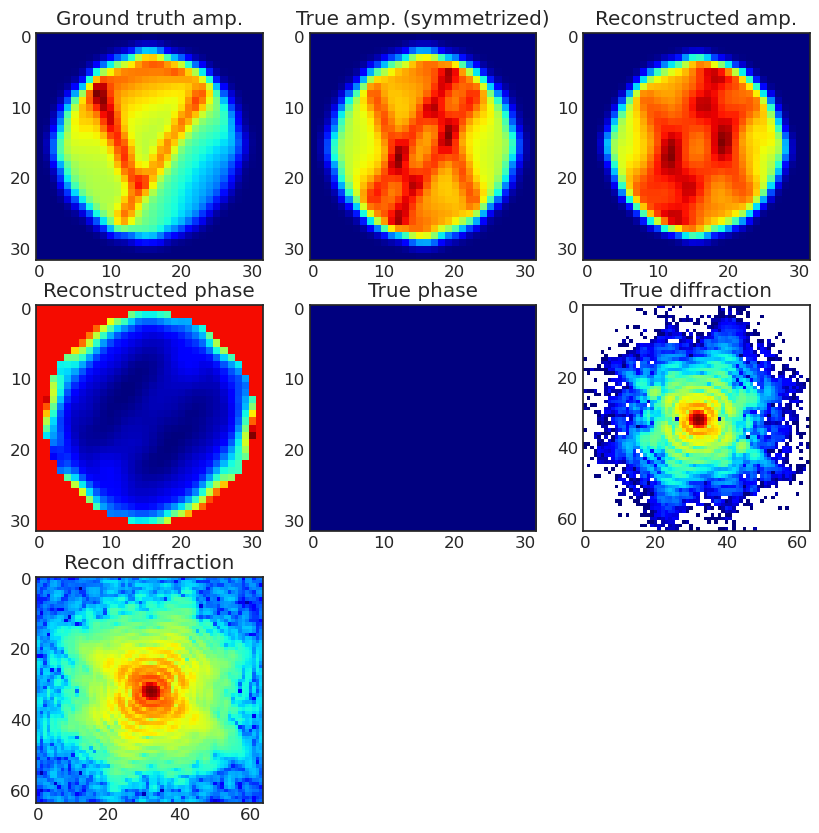

In [45]:
summarize(10)

/tmp/ipykernel_347436/3031347760.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i], cmap = 'jet')


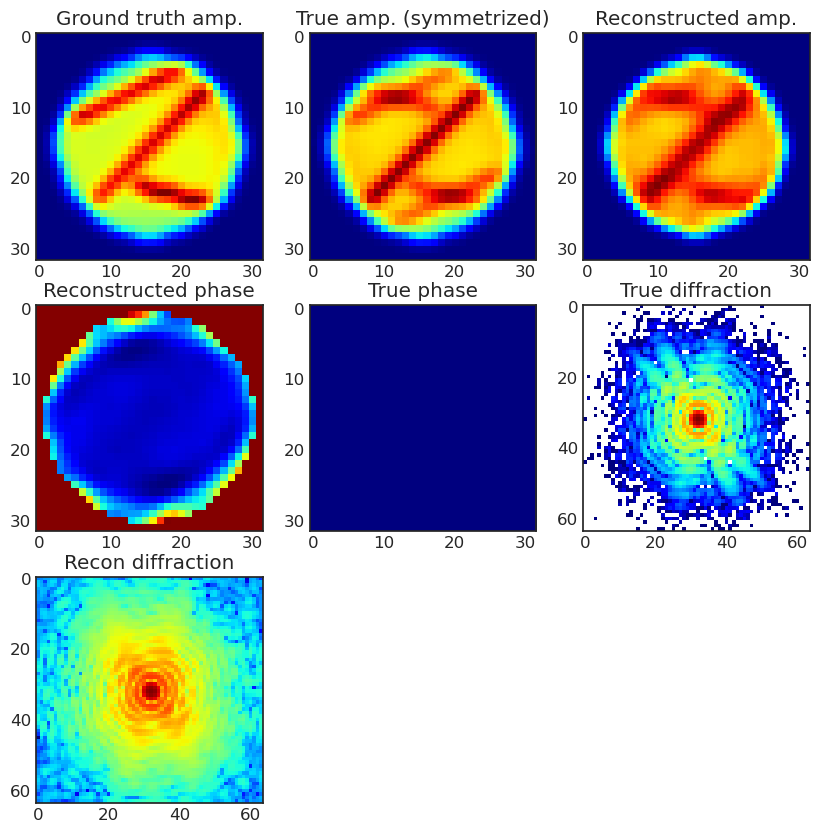

In [46]:
i = 501
summarize(i)

/tmp/ipykernel_347436/3031347760.py:55: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(X_test)[i], cmap = 'jet')


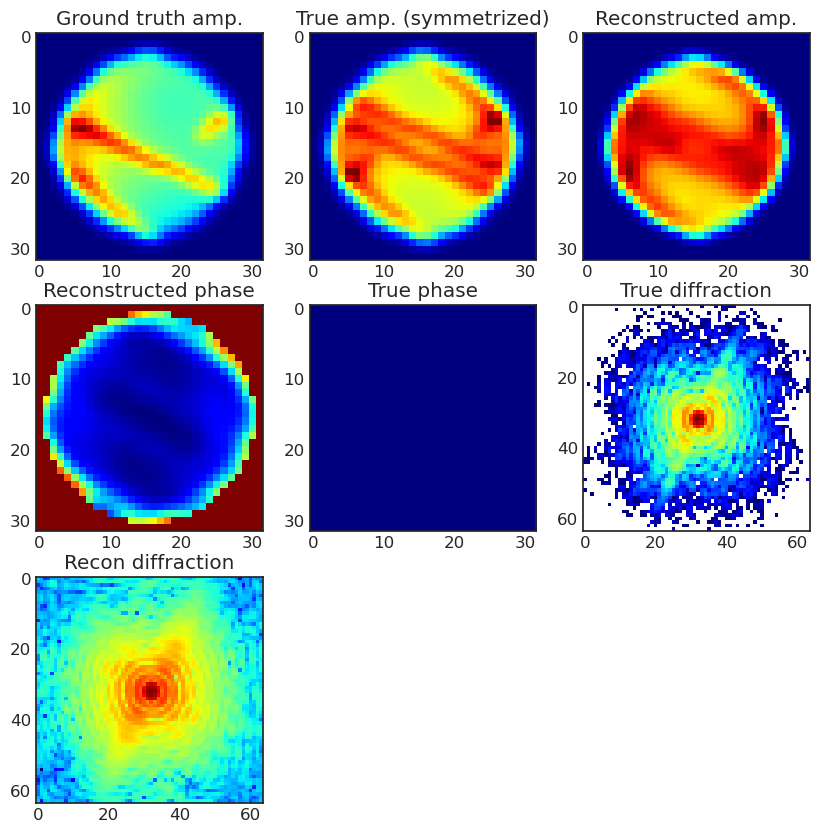

In [47]:
summarize(505)

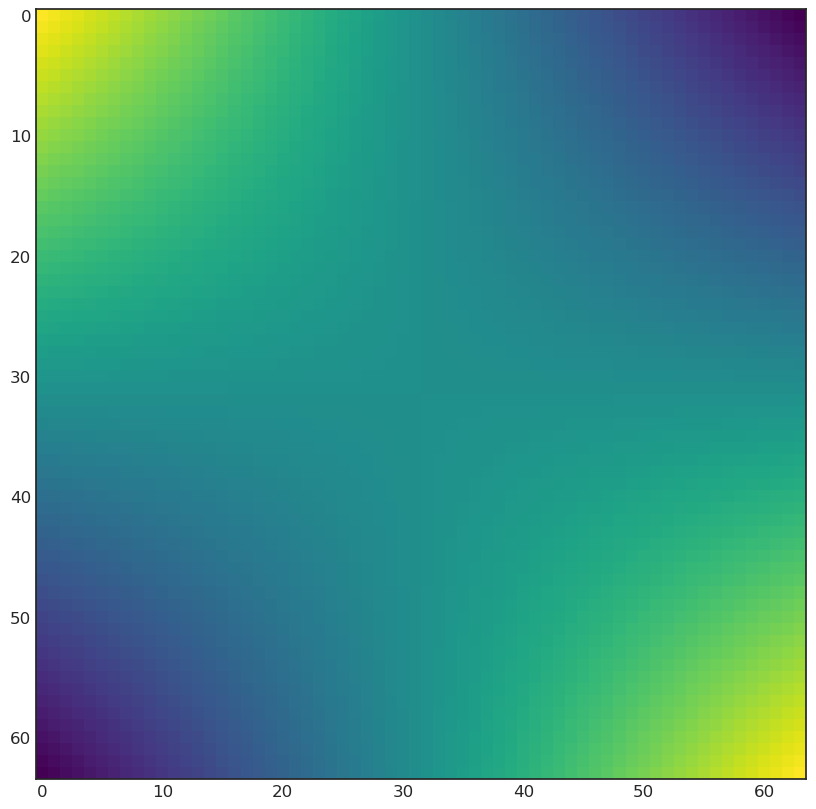

In [879]:
plt.imshow(Y_phi_test[i])

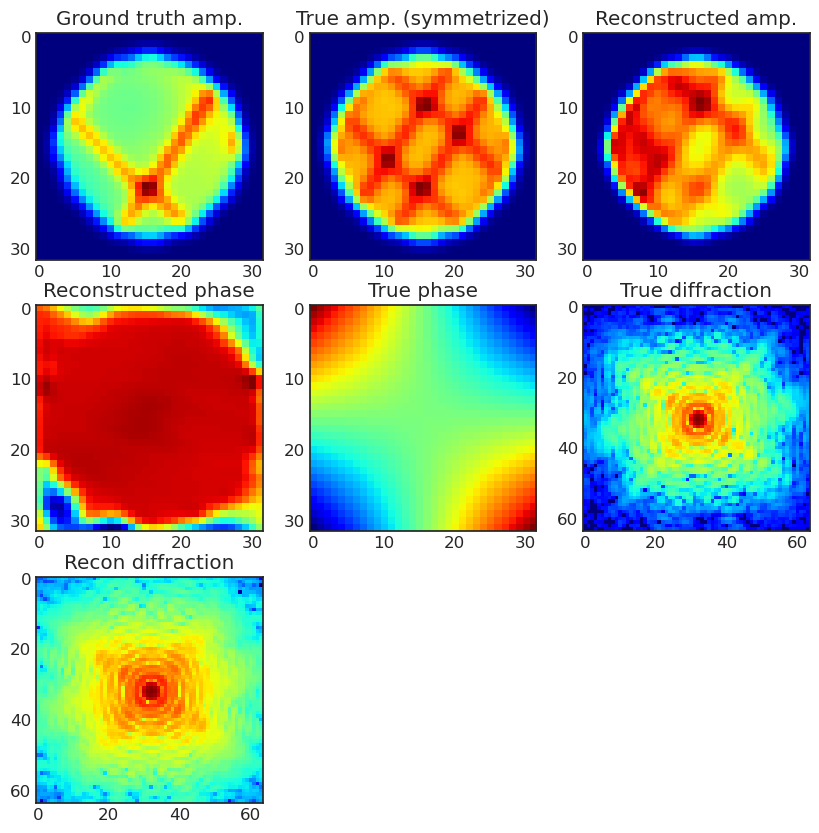

In [274]:
summarize(13)

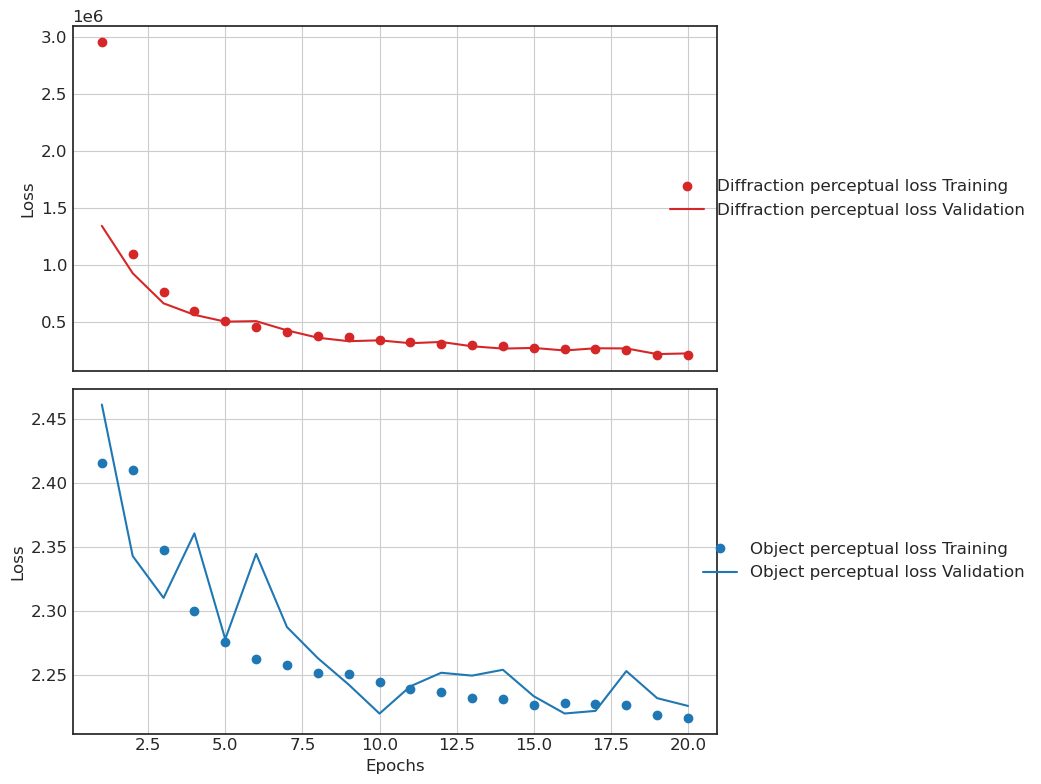

In [48]:
plt_metrics()

## 10^10 photons, MAE objective:

### Before global phase perturbation:

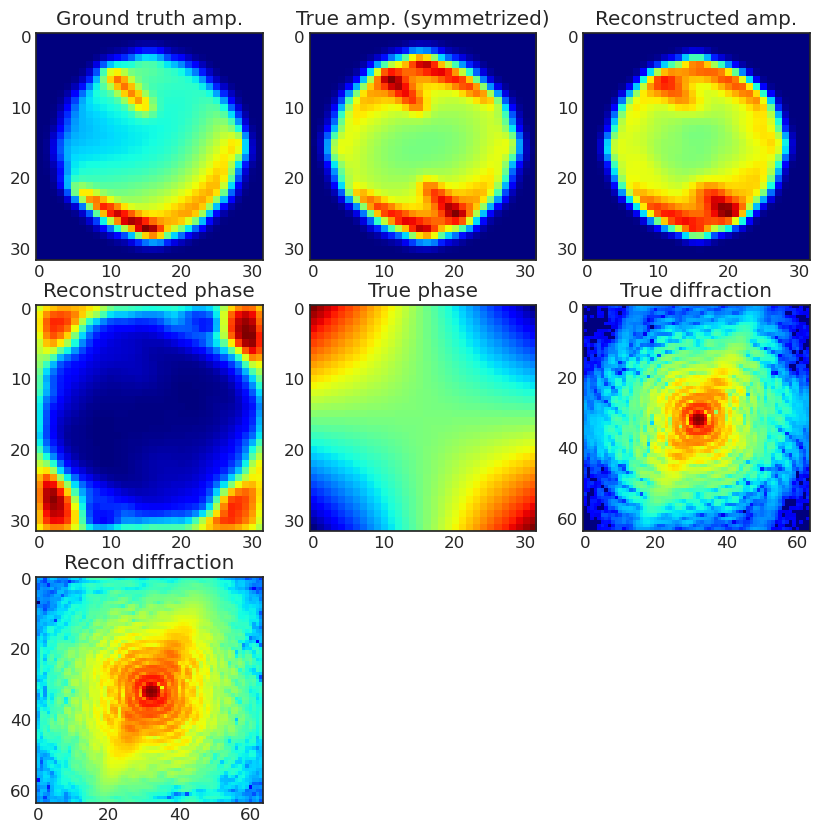

In [246]:
summarize(20)

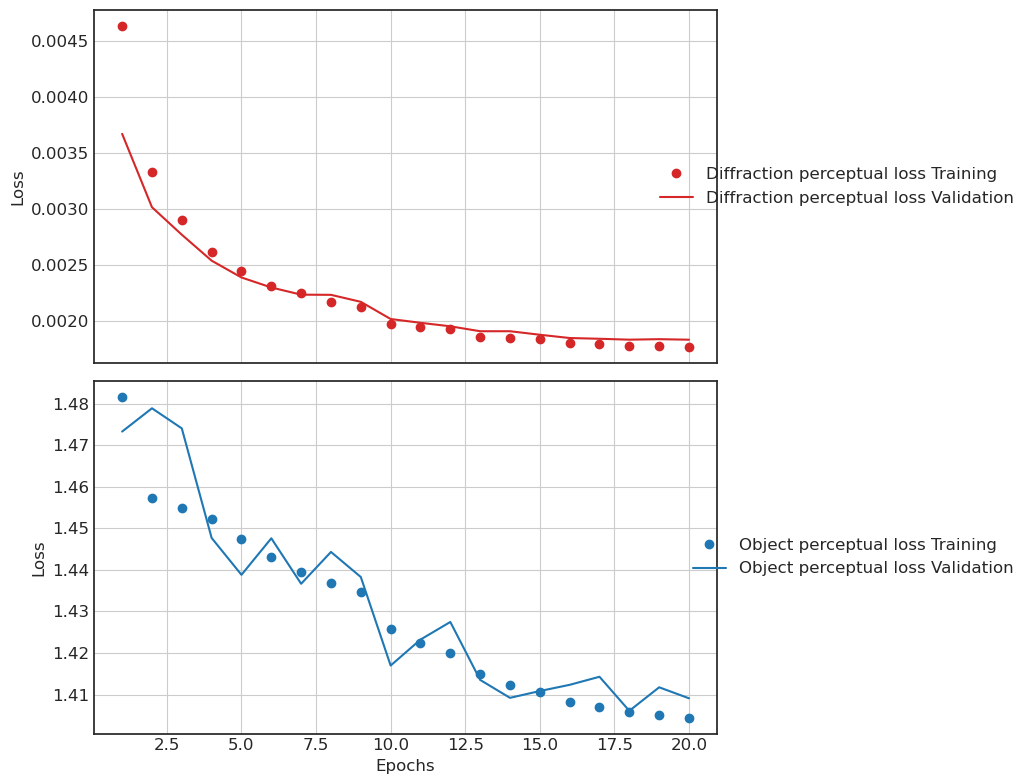

In [247]:
plt_metrics()

### After global phase perturbation:

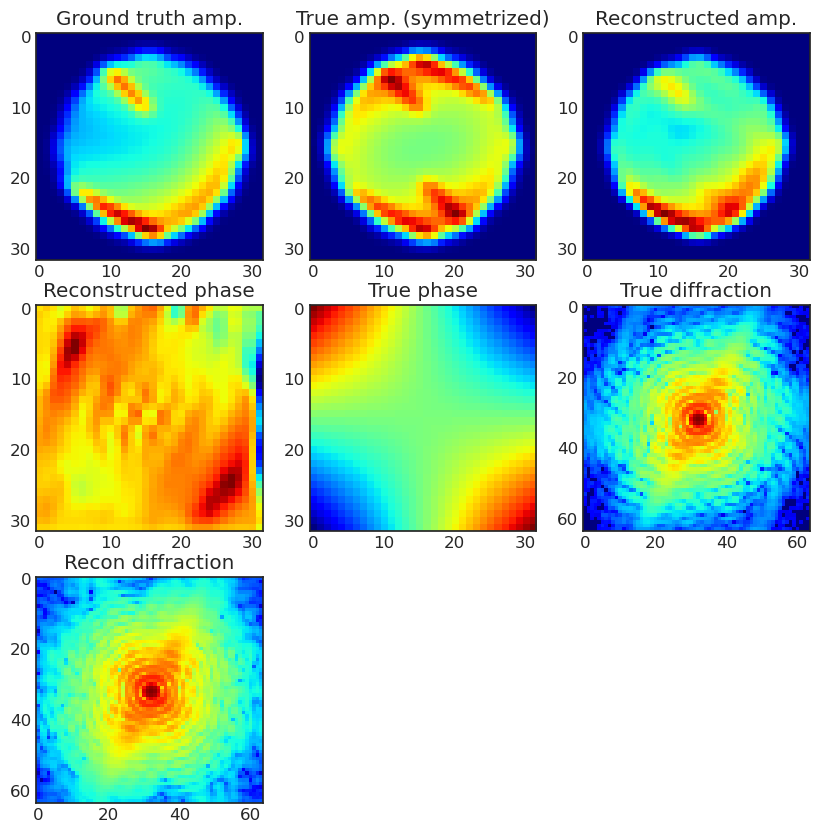

In [262]:
summarize(20)

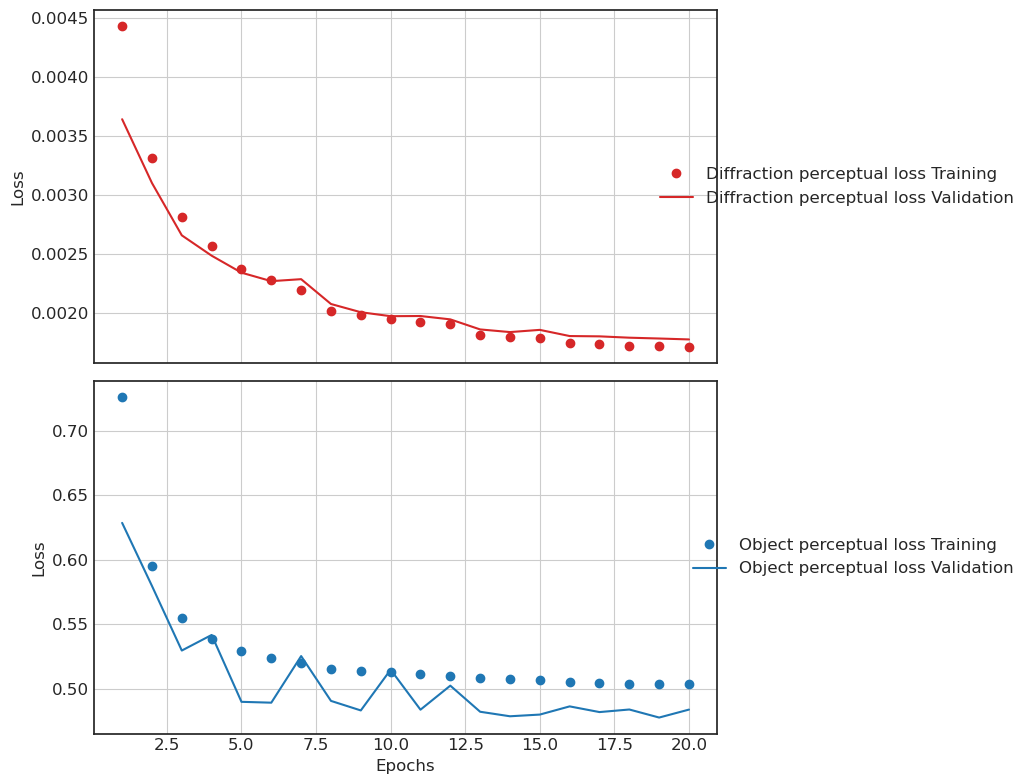

In [261]:
plt_metrics()

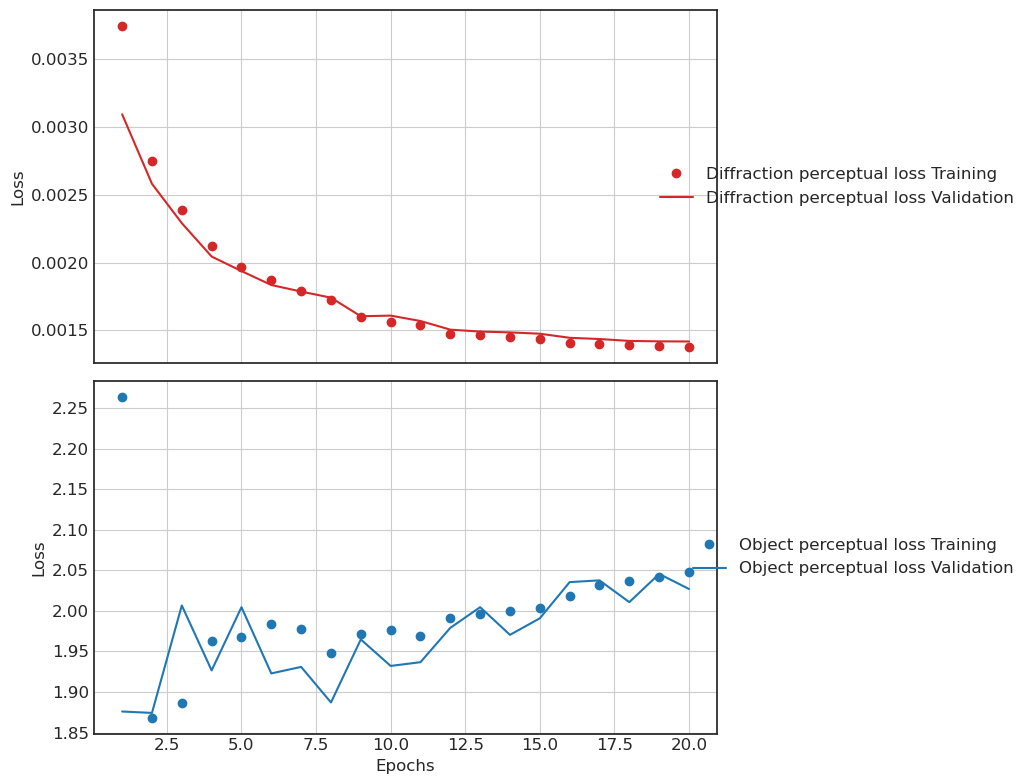

In [121]:
plt_metrics()

### 10^8 photons, MAE loss:

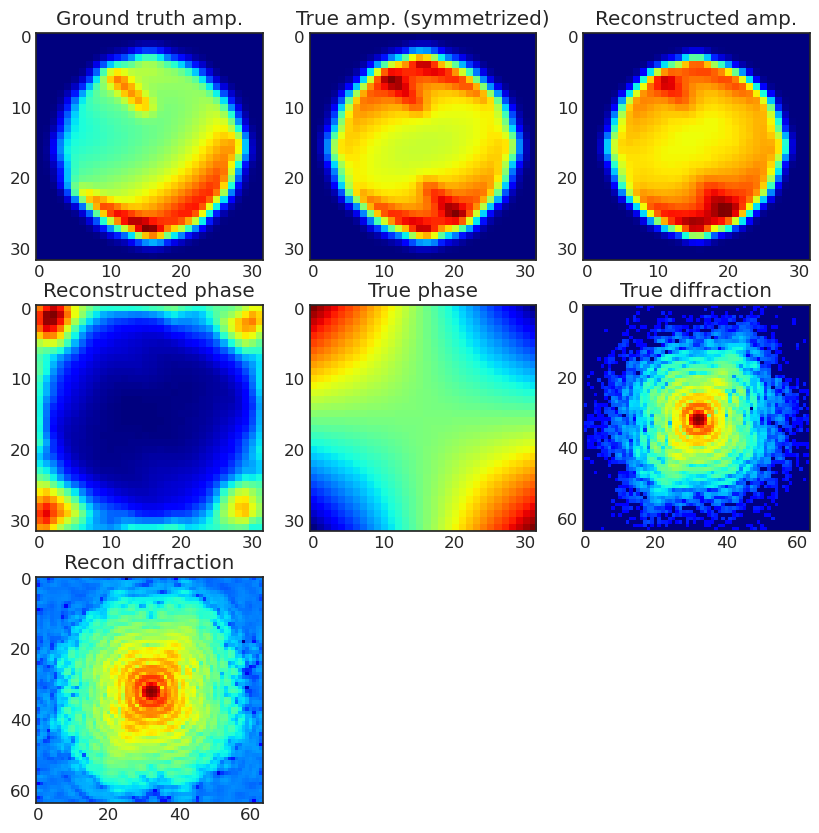

In [152]:
summarize(20)

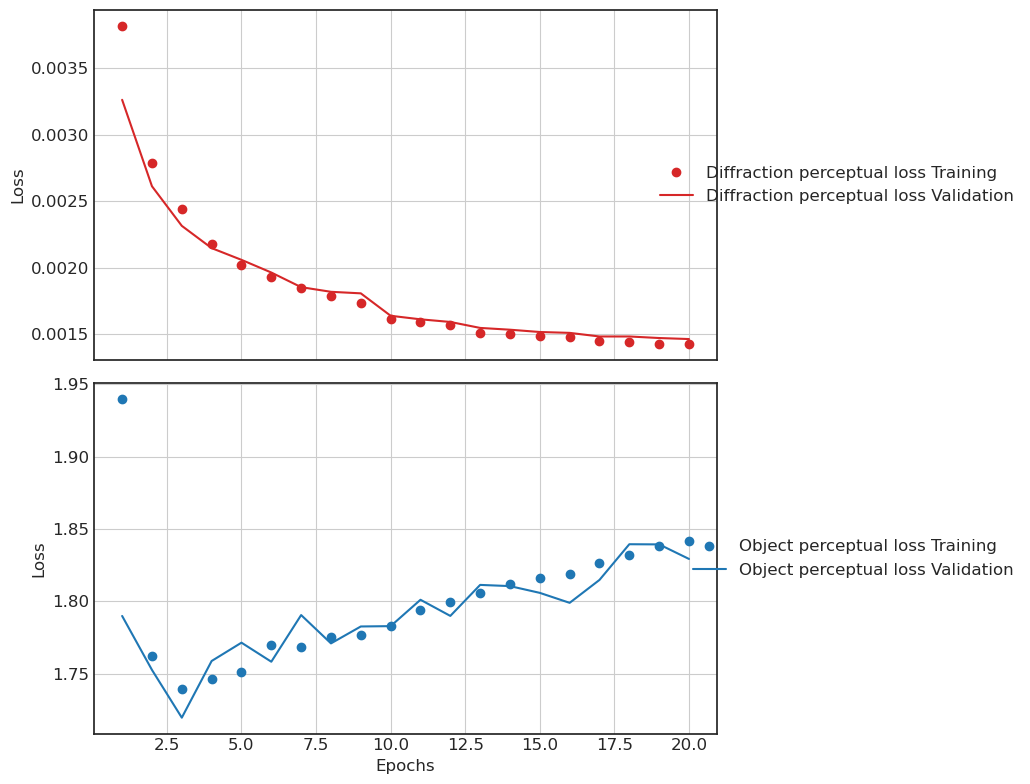

In [153]:
plt_metrics()

### 10^10 photons, perceptual loss:

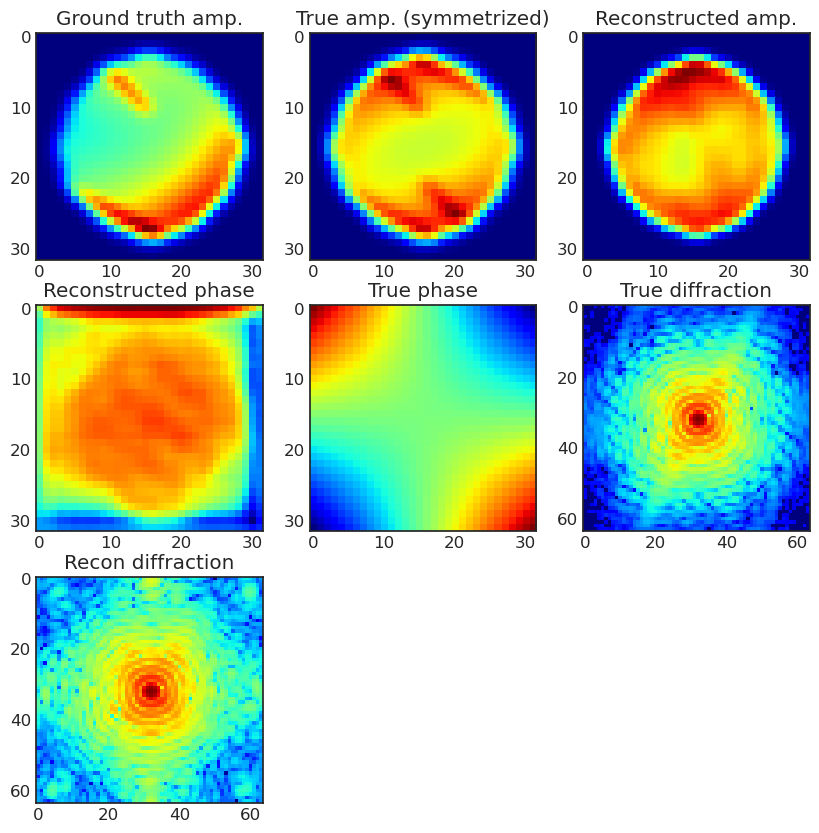

In [126]:
summarize(20)

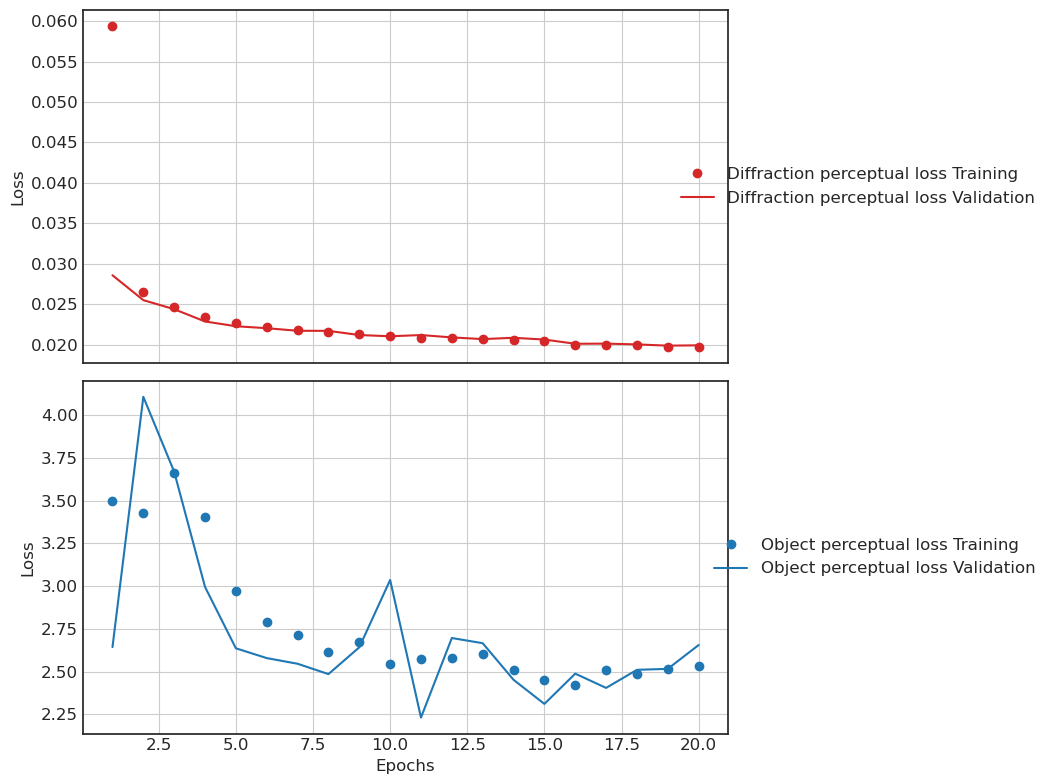

In [127]:
plt_metrics()

### 10^8 photons, perceptual loss:

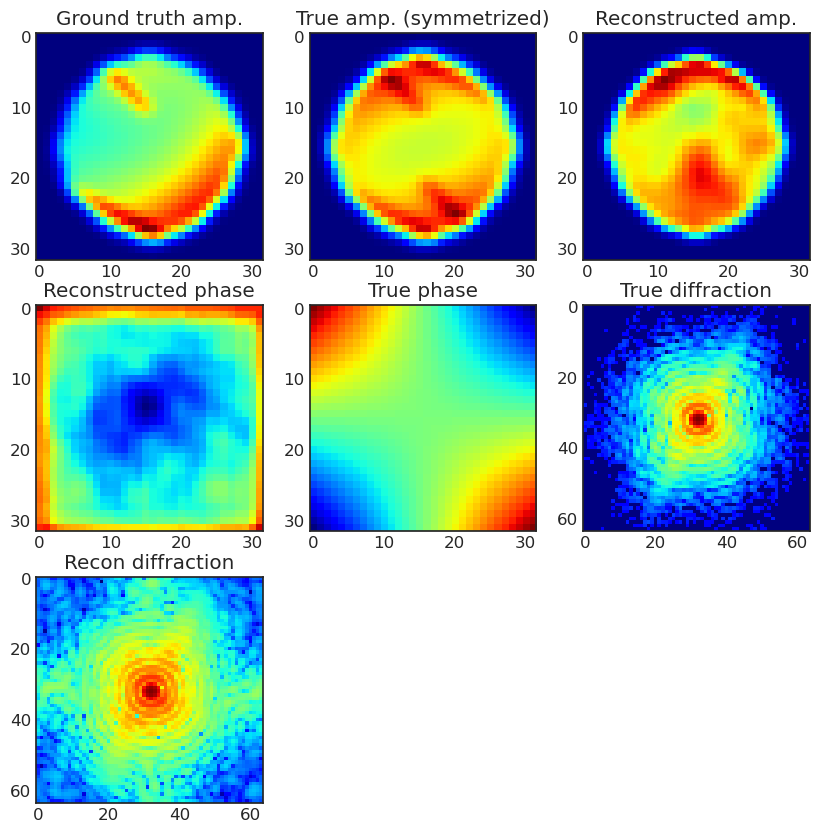

In [168]:
summarize(20)

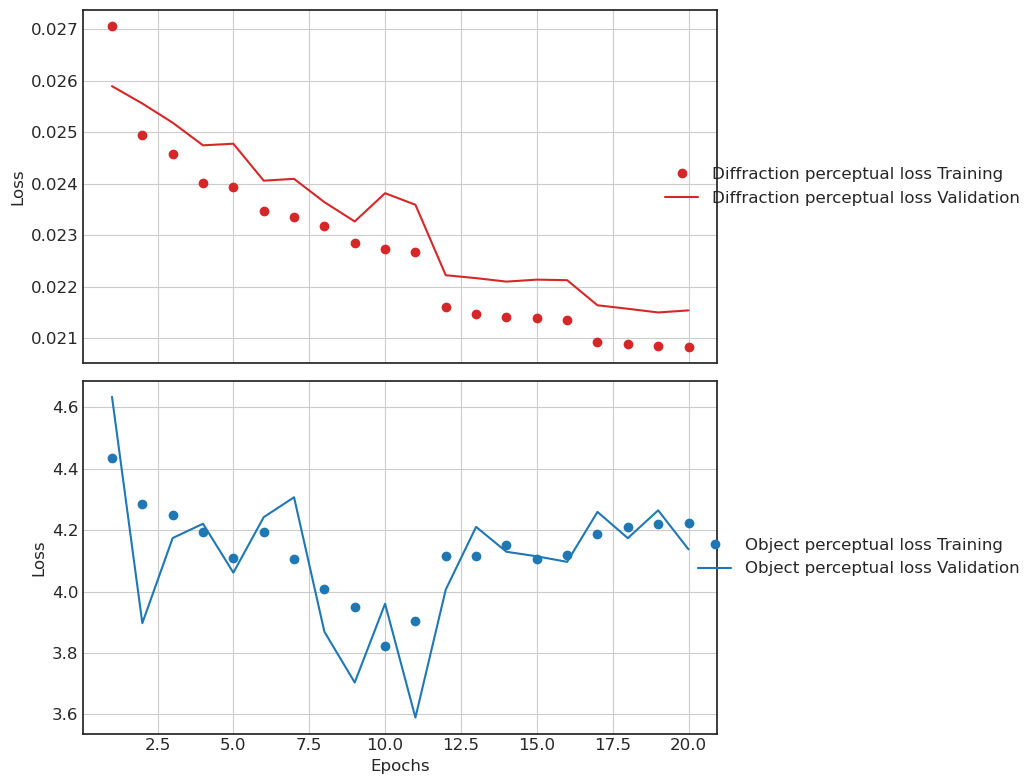

In [169]:
plt_metrics()

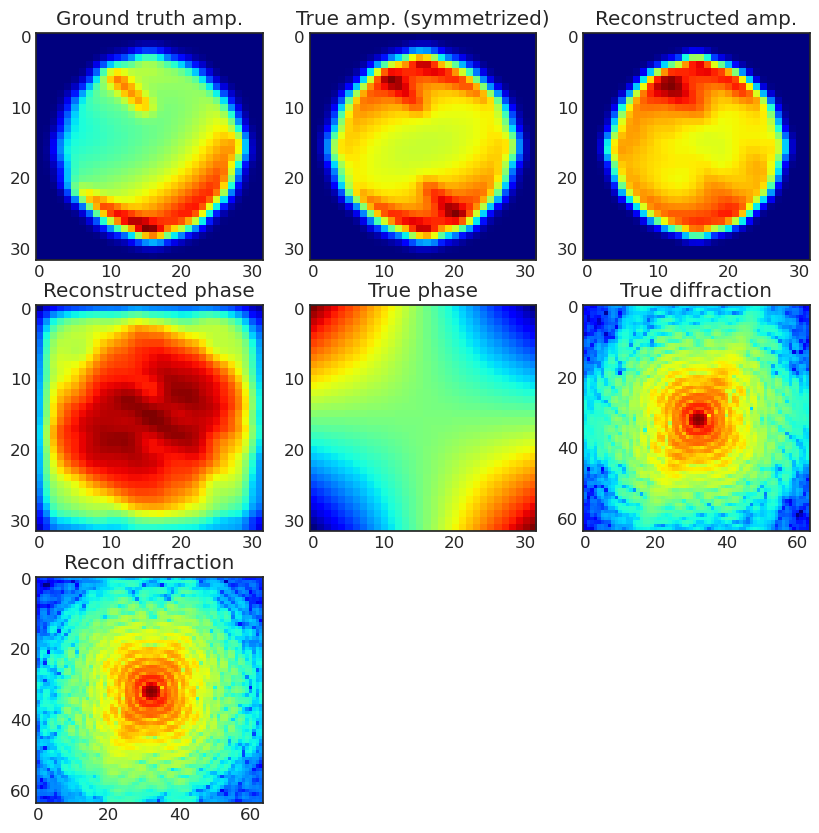

In [72]:
# a, b, loss = autoencoder.predict([X_test])
summarize(20)

### More examples of reconstructions:

In [ ]:
i = 501

In [ ]:
summarize(i)

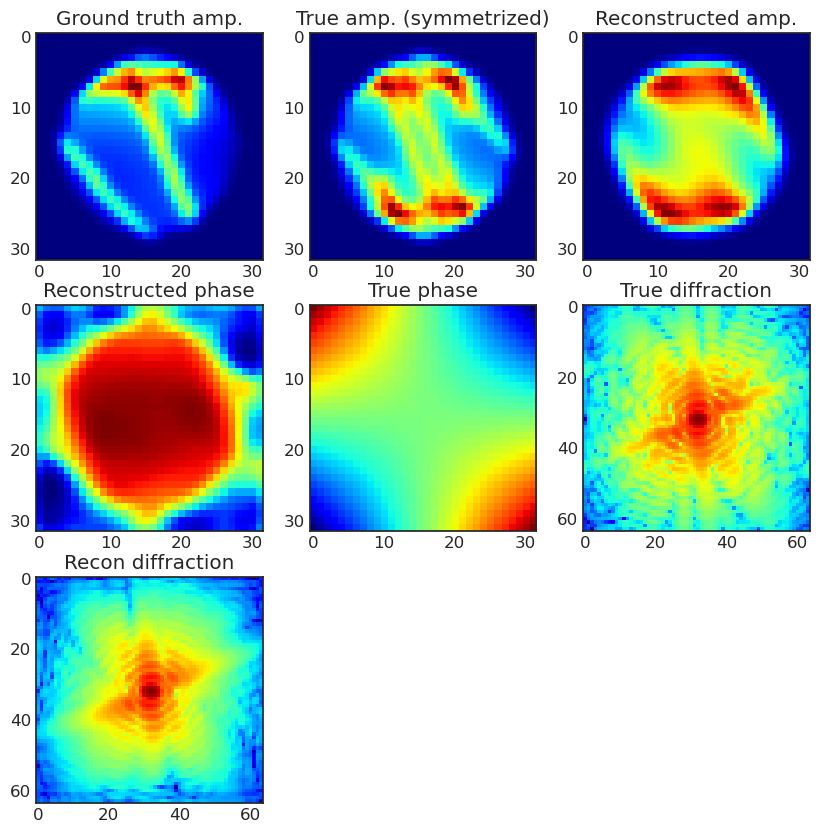

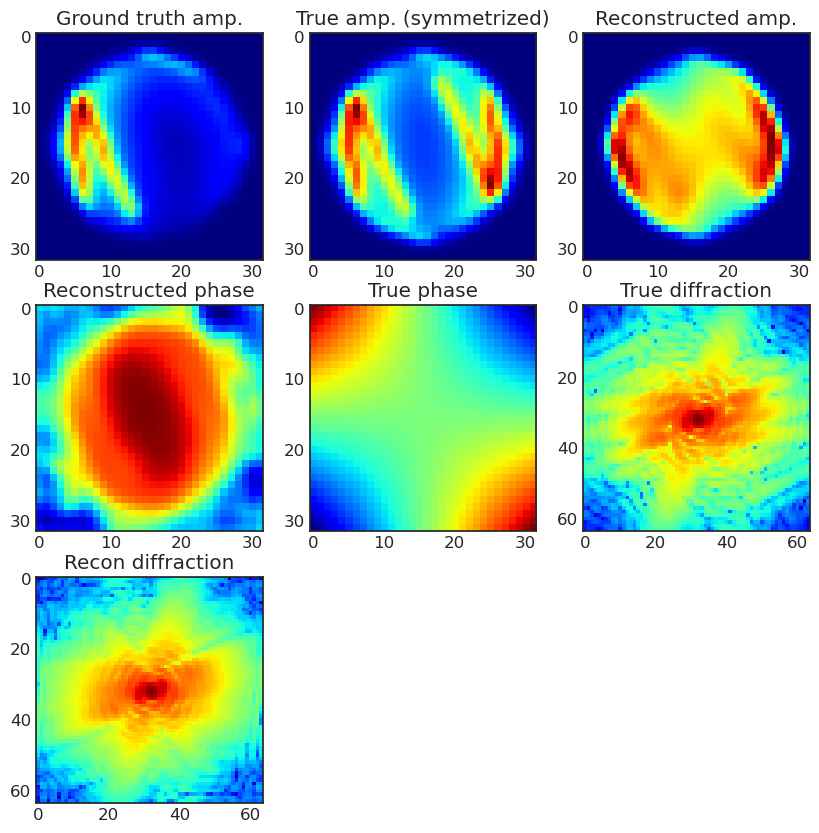

In [49]:
summarize(505)

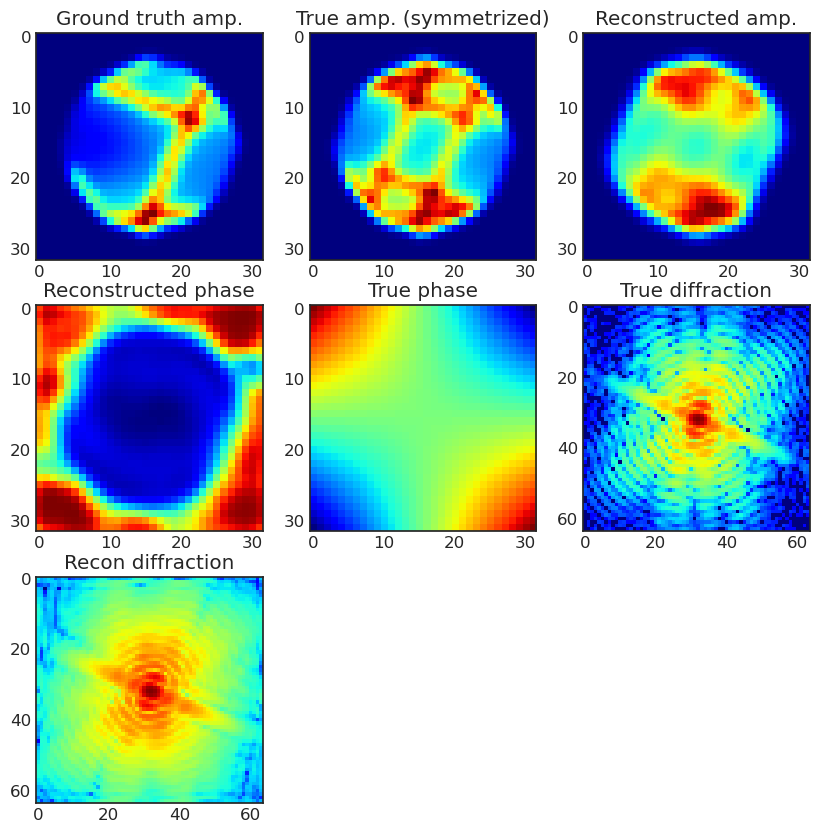

In [92]:
summarize(505)

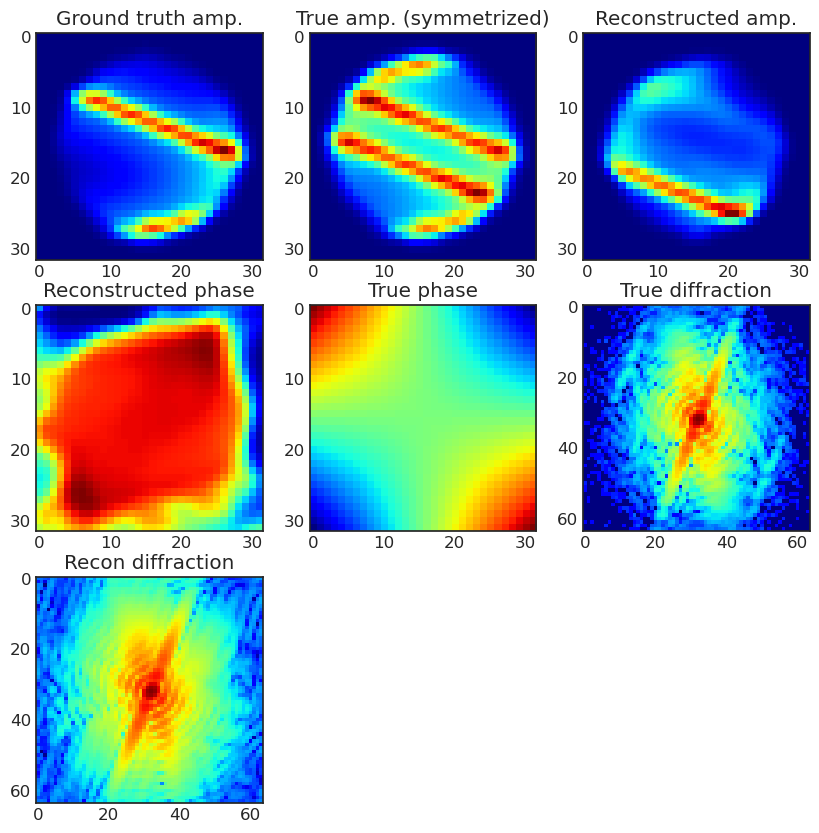

In [48]:
summarize(505)

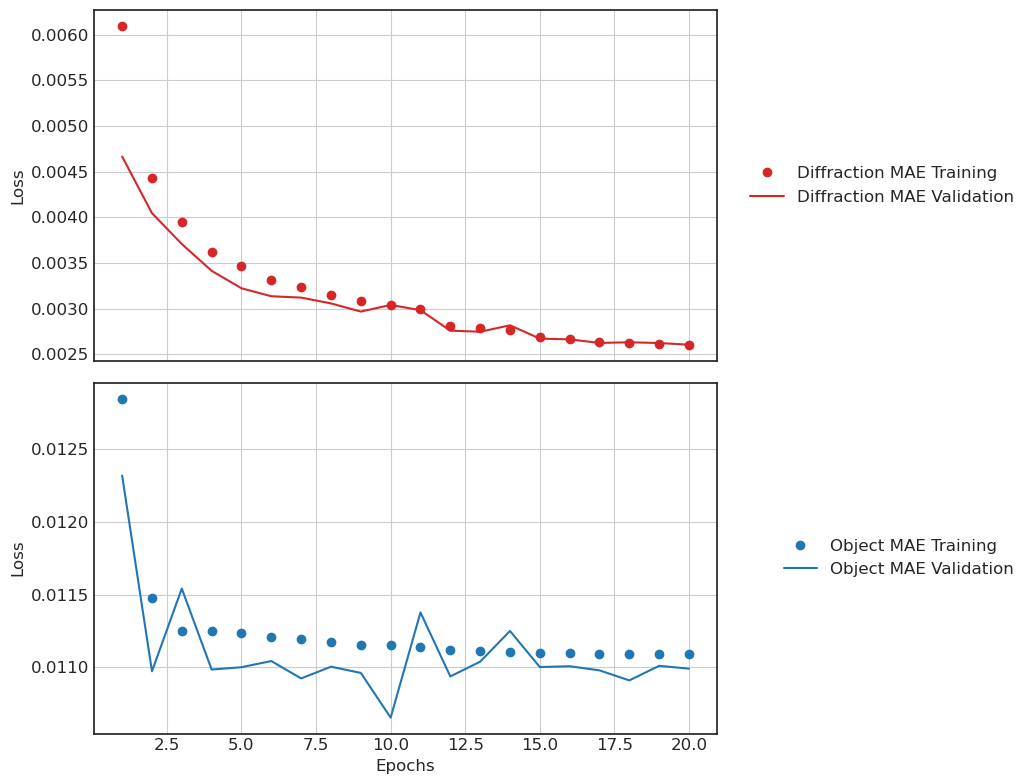

In [52]:
plt_metrics()

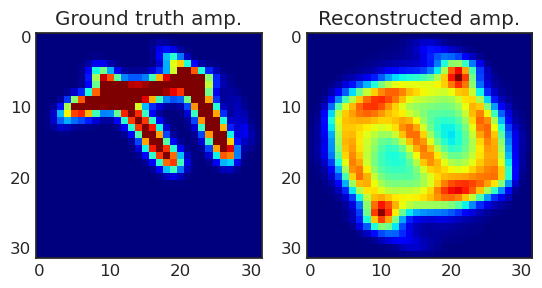

In [88]:
def cropshow(arr, *args, **kwargs):
    arr = arr[16:-16, 16:-16]
    plt.imshow(arr, *args, **kwargs)
    
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = np.absolute(b)[i].max()

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

In [54]:
noisy, no = aux_model([X_test[:100]])

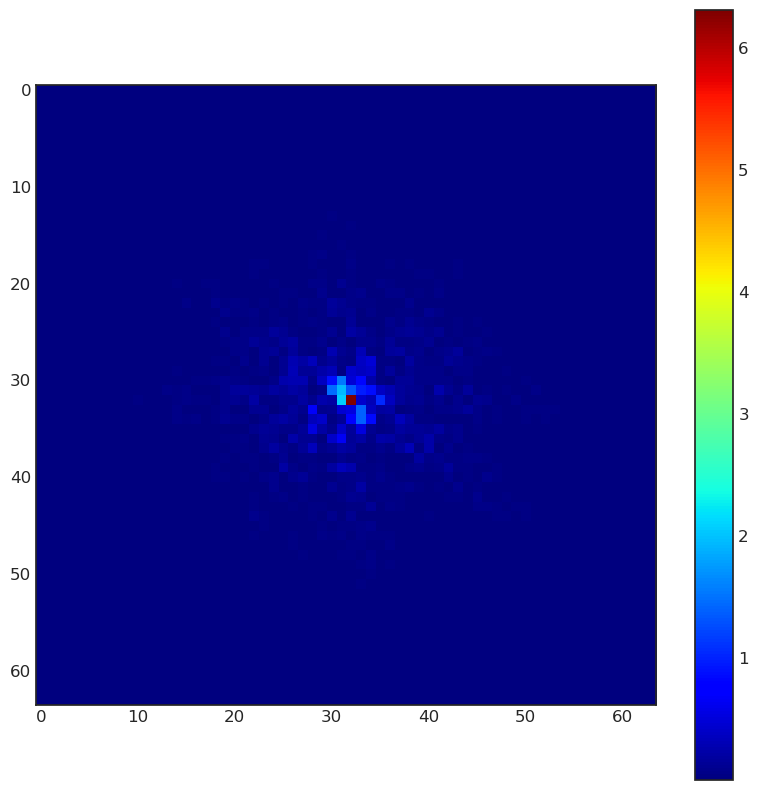

In [55]:
plt.imshow(np.absolute(noisy)[0], cmap = 'jet')
plt.colorbar()

In [56]:
c, d, _ = autoencoder.predict([noisy])

4/4 [==============================] - 0s 26ms/step


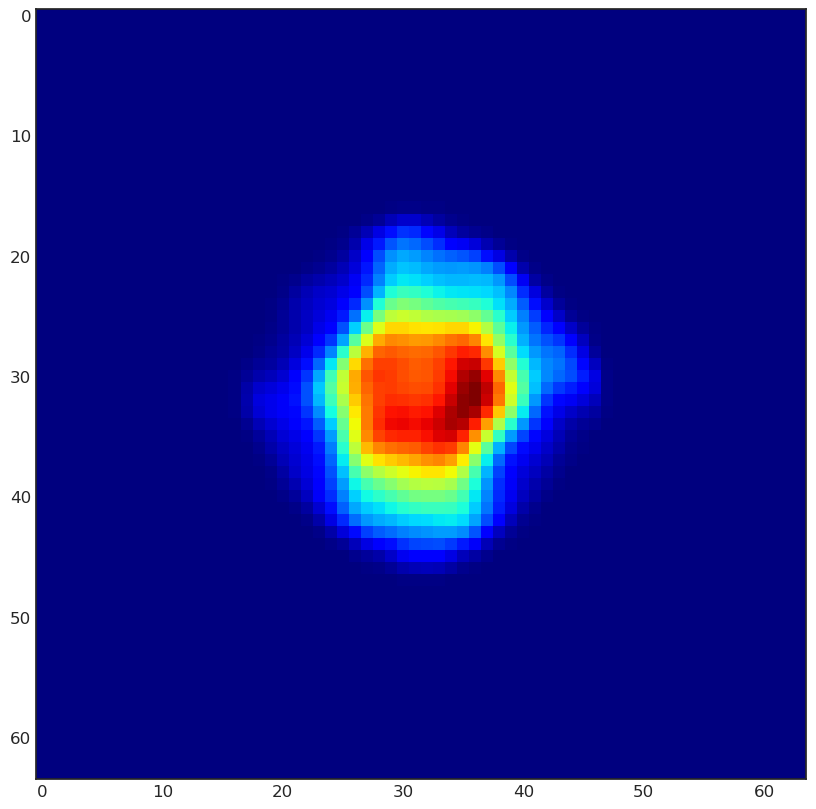

In [57]:
plt.imshow(np.absolute(d)[0], cmap = 'jet')

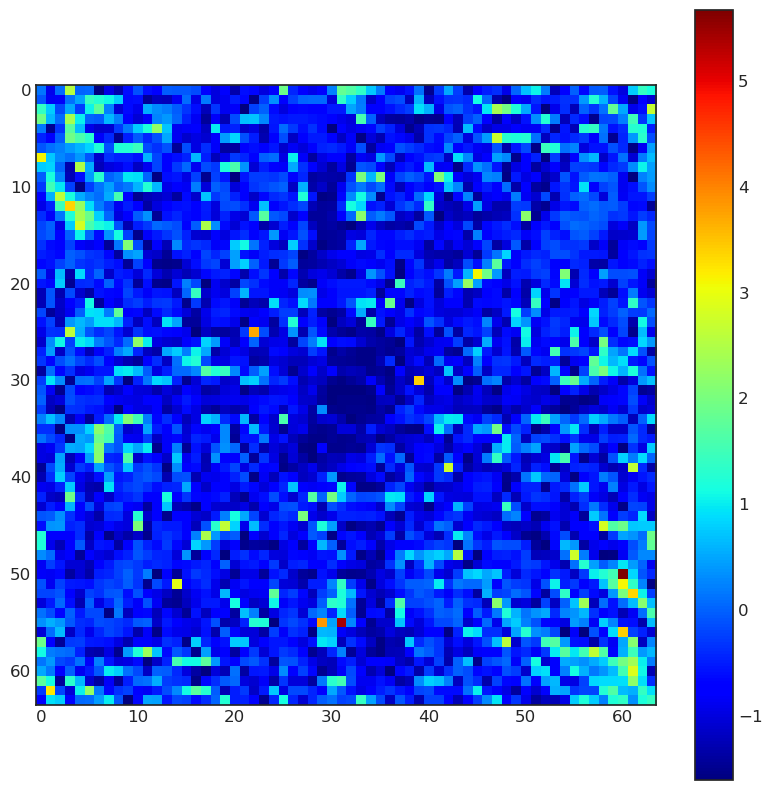

In [58]:
plt.imshow(np.log(.2 + np.abs((a[i] - X_test[i]) / (X_test[i] + 1e-9))), cmap ='jet')
plt.colorbar()

In [71]:
tmp2 = Y_I_test

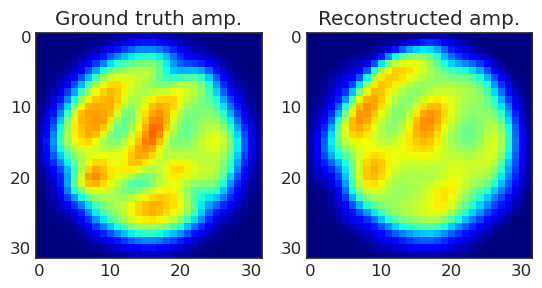

In [46]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

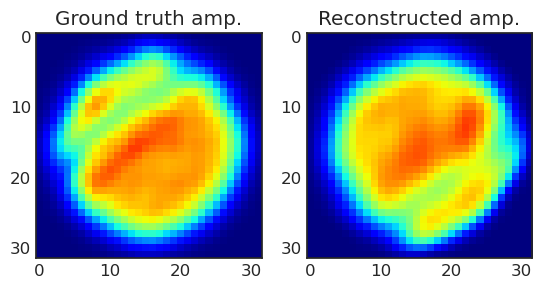

In [36]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
# vmax = tmp2[i].max() * norm
vmin = 0
vmax = 1

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmin = vmin, vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmin = vmin, vmax = vmax)
# plt.colorbar()

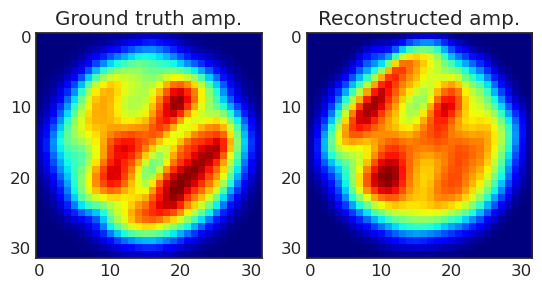

In [37]:
off = 1
norm =  (np.absolute(b)[i].max() / tmp2[i].max())
vmax = tmp2[i].max() * norm

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.title('Ground truth amp.')
cropshow((Y_I_test[i]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.title('Reconstructed amp.')
cropshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

In [38]:
amplitude_difference(Y_I_test[i:i + 1], (np.absolute(b)[i:i + 1]))

tf.Tensor(0.014161492, shape=(), dtype=float32) tf.Tensor(0.012130551, shape=(), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.012130551>

In [62]:
# !ln ../xrd_clustering/notebooks/visualization.py

In [49]:
import visualization as vis
# reload(vis)

In [50]:
vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + 10])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + 10])

diffraction reconstruction


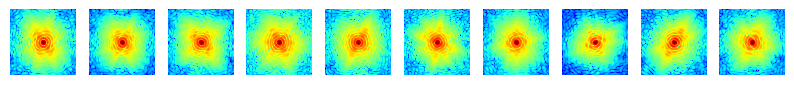

diffraction ground truth


/tmp/ipykernel_347436/3727551343.py:8: RuntimeWarning: divide by zero encountered in log
  vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + 10])


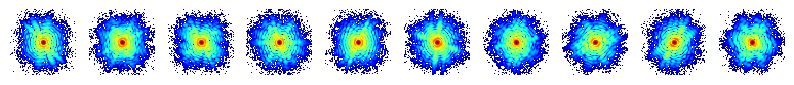

object reconstruction (amp)


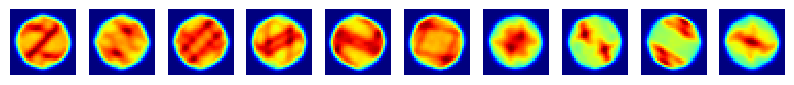

object ground truth


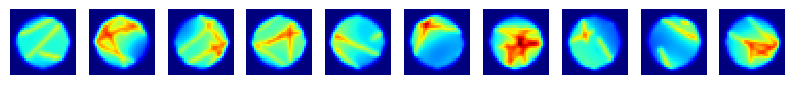

In [52]:
vmin = np.min(Y_I_test[:, 16:-16, 16:-16][i:i + 10])
vmax = np.max(Y_I_test[:, 16:-16, 16:-16][i:i + 10])

print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a[:, :, :, 0]))[i:i + 10])

print('diffraction ground truth')
vis.display_imgs(np.log(np.absolute(X_test[:, :, :, 0]))[i:i + 10])

print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
# print('object reconstruction (phase)')
# vis.display_imgs(np.angle(b[:, 16:-16, 16:-16, 0])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16, 0][i:i + 10], vmin = vmin, vmax = vmax)

3 epochs

diffraction reconstruction


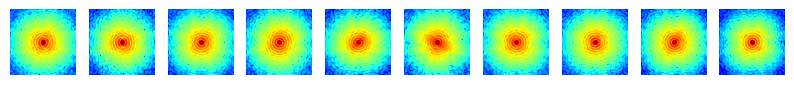

object reconstruction (amp)


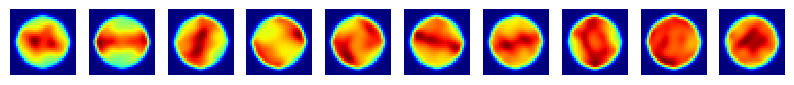

object reconstruction (phase)


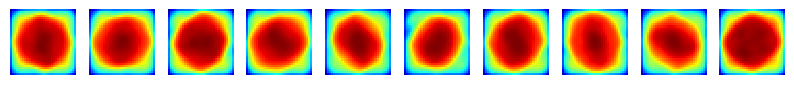

object ground truth (symmetric)


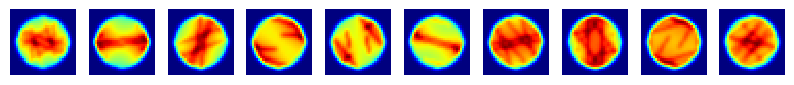

object ground truth


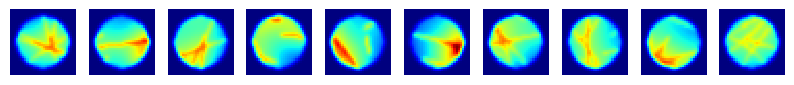

In [201]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

20 epochs:

diffraction reconstruction


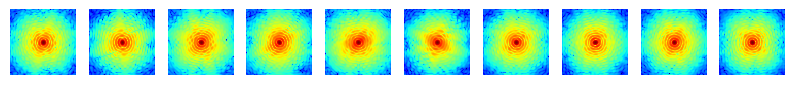

object reconstruction (amp)


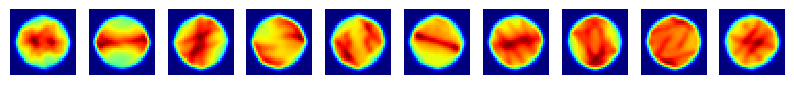

object reconstruction (phase)


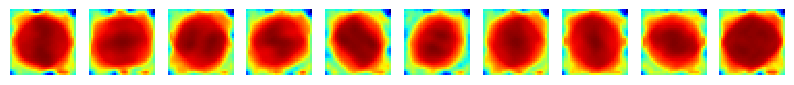

object ground truth (symmetric)


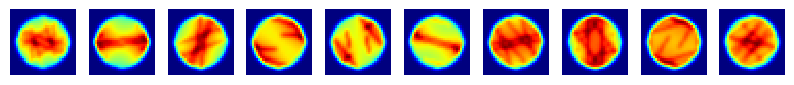

object ground truth


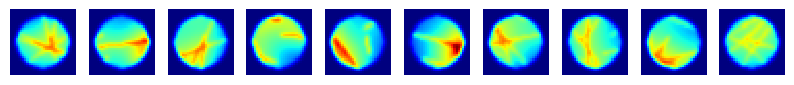

In [203]:
print('diffraction reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
print('object reconstruction (amp)')
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object reconstruction (phase)')
vis.display_imgs(np.angle(b[:, 16:-16, 16:-16])[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth (symmetric)')
vis.display_imgs(np.absolute(symmetrize_3d(Y_I_test[:, 16:-16, 16:-16]))[i:i + 10])#, vmin = vmin, vmax = vmax)
print('object ground truth')
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10], vmin = vmin, vmax = vmax)

ground truth


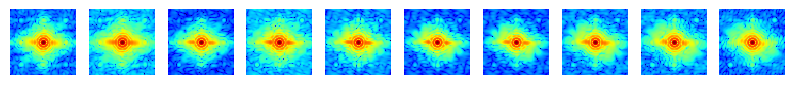

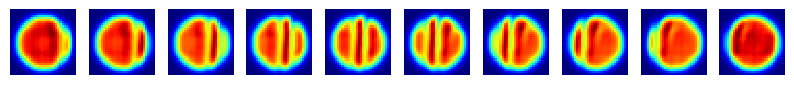

reconstruction


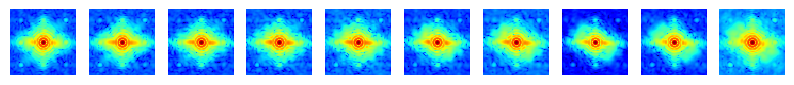

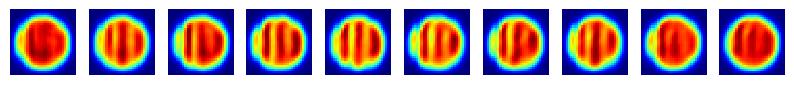

In [180]:
i = 800
print('ground truth')
vis.display_imgs(np.log(X_test[i:i + 10]))
vis.display_imgs(Y_I_test[:, 16:-16, 16:-16][i:i + 10])


print('reconstruction')
vis.display_imgs(np.log(np.absolute(a))[i:i + 10])
vis.display_imgs(np.absolute(b[:, 16:-16, 16:-16])[i:i + 10])

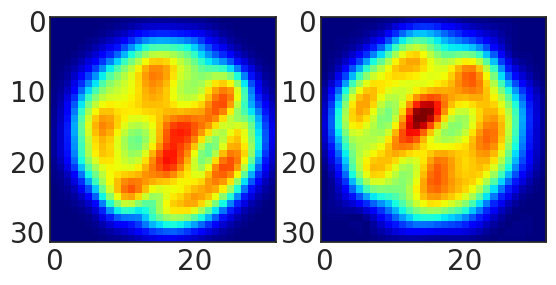

In [110]:
off = 1
i = 607

aa, bb = 1, 2
plt.subplot(aa, bb, 1)
plt.imshow((Y_I_test[i, 16:-16, 16:-16]), cmap = 'jet', vmax = vmax)

plt.subplot(aa, bb, 2)
plt.imshow((np.absolute(b))[i], cmap = 'jet', vmax = vmax)
# plt.colorbar()

## save model

In [249]:
history.history.keys()

dict_keys(['loss', 'pred_amplitude_loss', 'padded_obj_loss', 'pred_amplitude_1_loss', 'val_loss', 'val_pred_amplitude_loss', 'val_padded_obj_loss', 'val_pred_amplitude_1_loss', 'lr'])

In [250]:
np.save(path+'str_history', history.history)

In [251]:
# model.load_weights(checkpoint_filepath)

In [252]:
# val_losses=hist.history['val_loss']
# min_epoch=np.argmin(val_losses)+1
# print (min_epoch)
# np.save(path+'%s/min_epoch' %(wt_path), min_epoch)
autoencoder.save('{}.h5'.format(wt_path))